# Experimento Softmax

<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación del entorno


In [1]:
# Configurar el path para imports
import sys
import os

# Añadir el directorio k_brazos al path de Python
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
k_brazos_dir = notebook_dir if 'k_brazos' in notebook_dir else os.path.join(notebook_dir, 'k_brazos')
if k_brazos_dir not in sys.path:
    sys.path.insert(0, k_brazos_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Added to path: {k_brazos_dir}")

Working directory: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos
Added to path: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos


In [2]:
#@title Importamos todas las clases y funciones
from src.algorithms.softmax import Softmax

import numpy as np
from typing import List

from src.arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics

from src.utils import SEMILLA

from src.run_experiment import run_experiment

## Experimento

Vamos a empezar definiendo las variables de nuestro marco experimental para probar y comparar los algoritmos. En nuestro experimento, nuestro bandido tendrá 10 brazos, el algoritmo se ejecutará durante mil pasos y esta ejecución la repetiremos unas 500 veces. Los resultados obtenidos serán el promedio de las recompensas obtenidas en cada paso para cada una de las ejecuciones.

Para el caso del algoritmo Softmax, tenemos el parámetro de temperatura tau, que controla el grado de exploración y explotación. Para nuestros experimentos, probaremos el algoritmo Softmax con 3 valores para este parámetro, que serán 0.1, 1 y 10. Con los valores más bajos, el algoritmo tendrá una tendencia a la explotación, mientras que valores más altos tendrán una mayor tendencia a la exploración. El valor de 1 es un valor equilibrado entre explotación y exploración.

In [3]:
# Parámetros del experimento
np.random.seed(SEMILLA)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [
    Softmax(k=k, tau=0.1),   # Casi Greedy (Explotación)
    Softmax(k=k, tau=1.0),   # Balanceado
    Softmax(k=k, tau=5.0),  # Muy aleatorio (Exploración)
]

## Ejecución del experimento con distribución Normal

Vamos a empezar realizando el experimento utilizando brazos con una distribución normal.

In [4]:
# Creación del bandit
bandido = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_normal, optimal_selections_normal, arm_stats_normal = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados distribución Normal

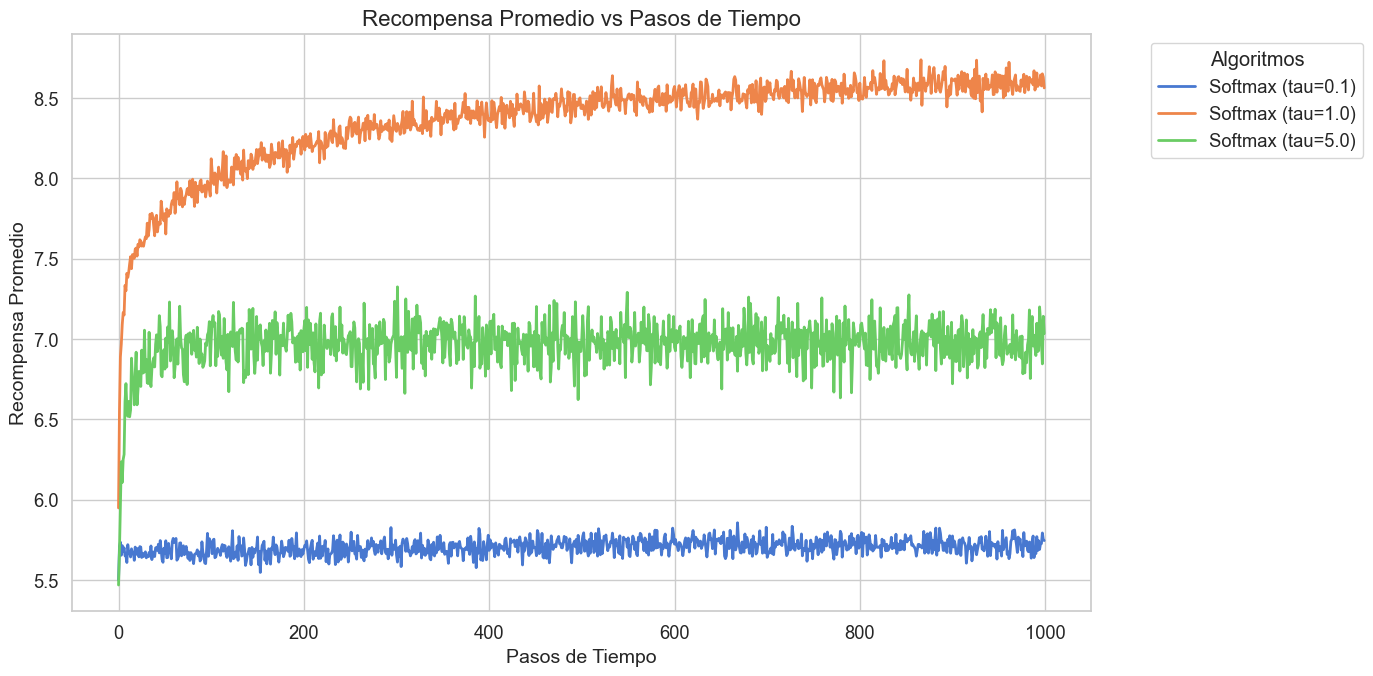

In [5]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)

### Análisis del Algoritmo Softmax (Distribución Normal)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y generando resultados mediocres que no mejoran a lo largo del tiempo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, podemos ver que el algoritmo va mejorando conforme el paso del tiempo, llegando a los pasos finales a superar una recompensa promedio de 8,5. Aún así, seguimos un poco lejos de 9,56 que era el valor de recompensa esperado.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso, podemos ver que al principio el algoritmo va mejorando, pero llega un punto en el que la exploración excesiva hace que el algoritmo no explote los mejores brazos y se quede generando unos resultados malos.

---

In [6]:
print(f"optimal selections: {optimal_selections_normal}")

optimal selections: [[0.102 0.104 0.104 ... 0.106 0.106 0.106]
 [0.118 0.136 0.146 ... 0.398 0.416 0.398]
 [0.096 0.098 0.086 ... 0.178 0.208 0.19 ]]


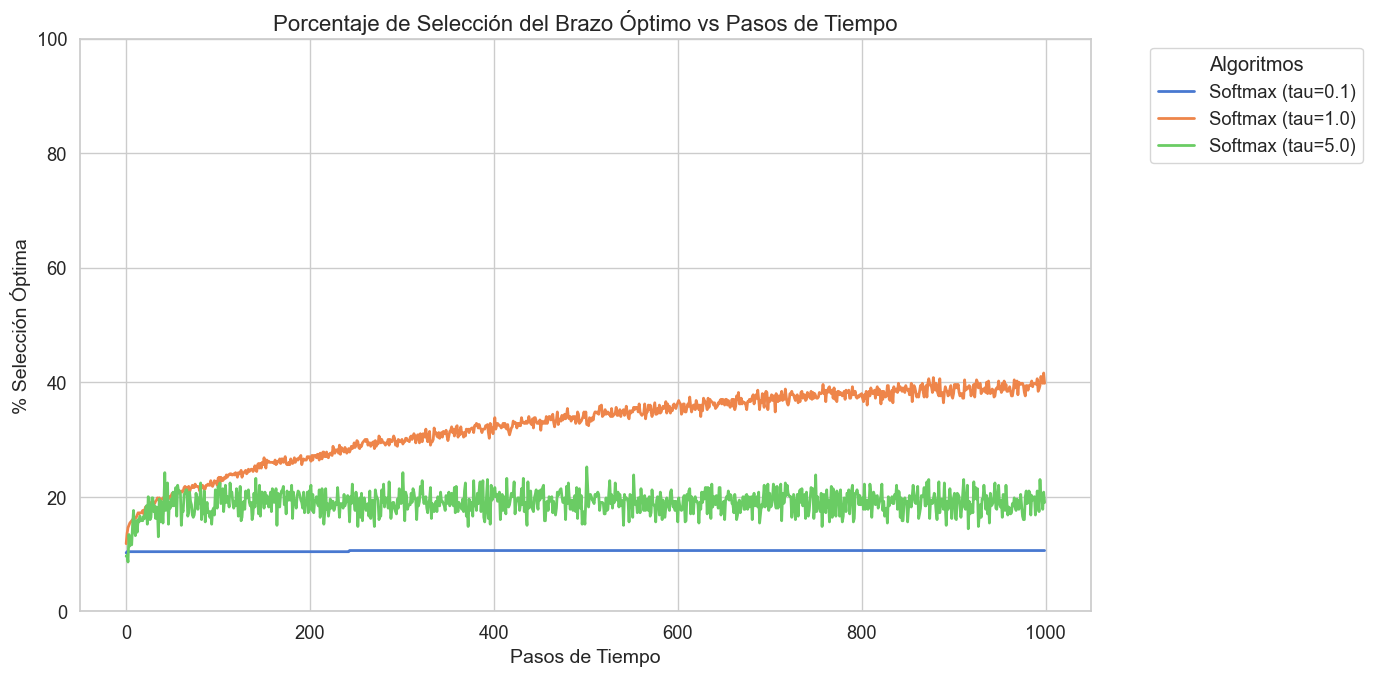

In [7]:
plot_optimal_selections(steps, optimal_selections_normal, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y solo llegamos a un 10% de selección del brazo óptimo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este paso podemos ver una mejora a lo largo del tiempo, pero aún así solo consigue alcanzar un 40% en el paso 1000. Esto cuadra ya que, como hemos visto en la anterior gráfica, no conseguiamos llegar a la recompensa objetivo.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que se quede en un 20% de selección del brazo óptimo.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

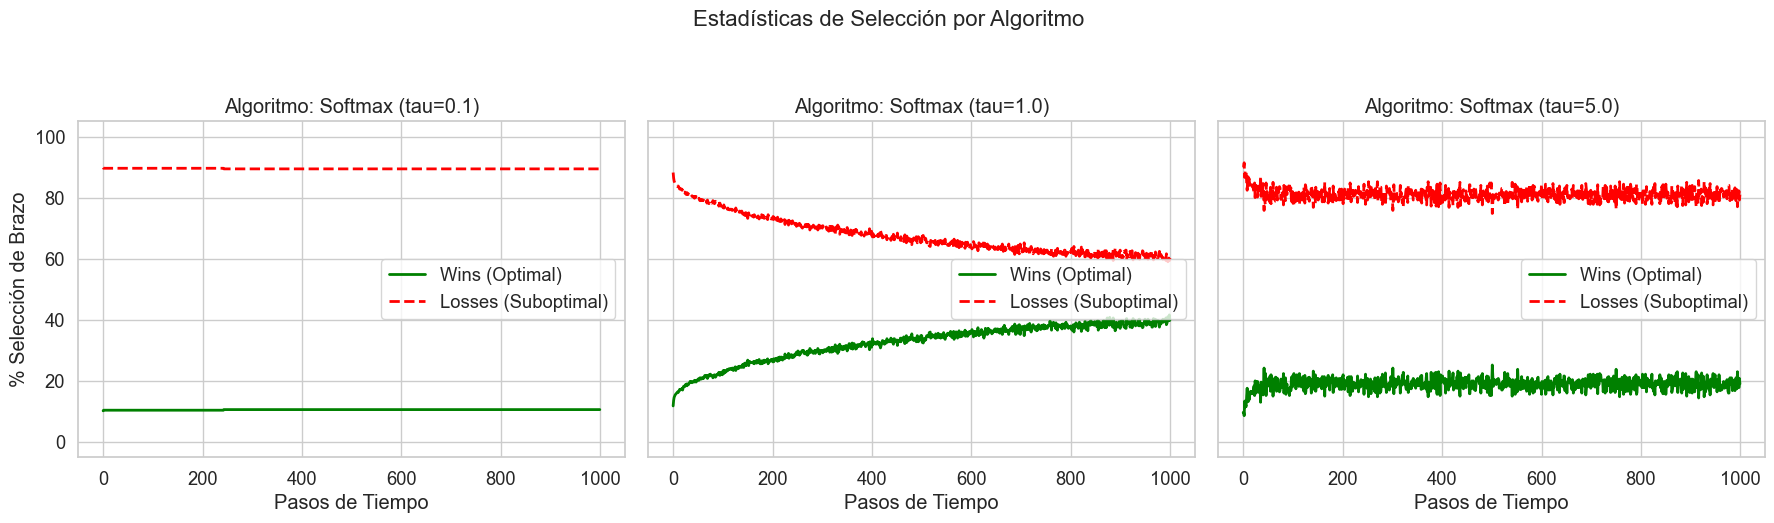

In [8]:
plot_arm_statistics(arm_stats_normal, algorithms)

---

## Ejecución del experimento con distribución Binomial

Ahora vamos a probar los algoritmos con la distribución binomial.

In [9]:
# Creación del bandit
bandido = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_binomial, optimal_selections_binomial, arm_stats_binomial = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.89), ArmBinomial(n=10, p=0.09), ArmBinomial(n=10, p=0.32), ArmBinomial(n=10, p=0.88), ArmBinomial(n=10, p=0.71), ArmBinomial(n=10, p=0.63), ArmBinomial(n=10, p=0.89), ArmBinomial(n=10, p=0.87), ArmBinomial(n=10, p=0.75), ArmBinomial(n=10, p=0.88)
Optimal arm: 7 with expected reward=8.9314114523604


### Visualización de los resultados del experimento Binomial

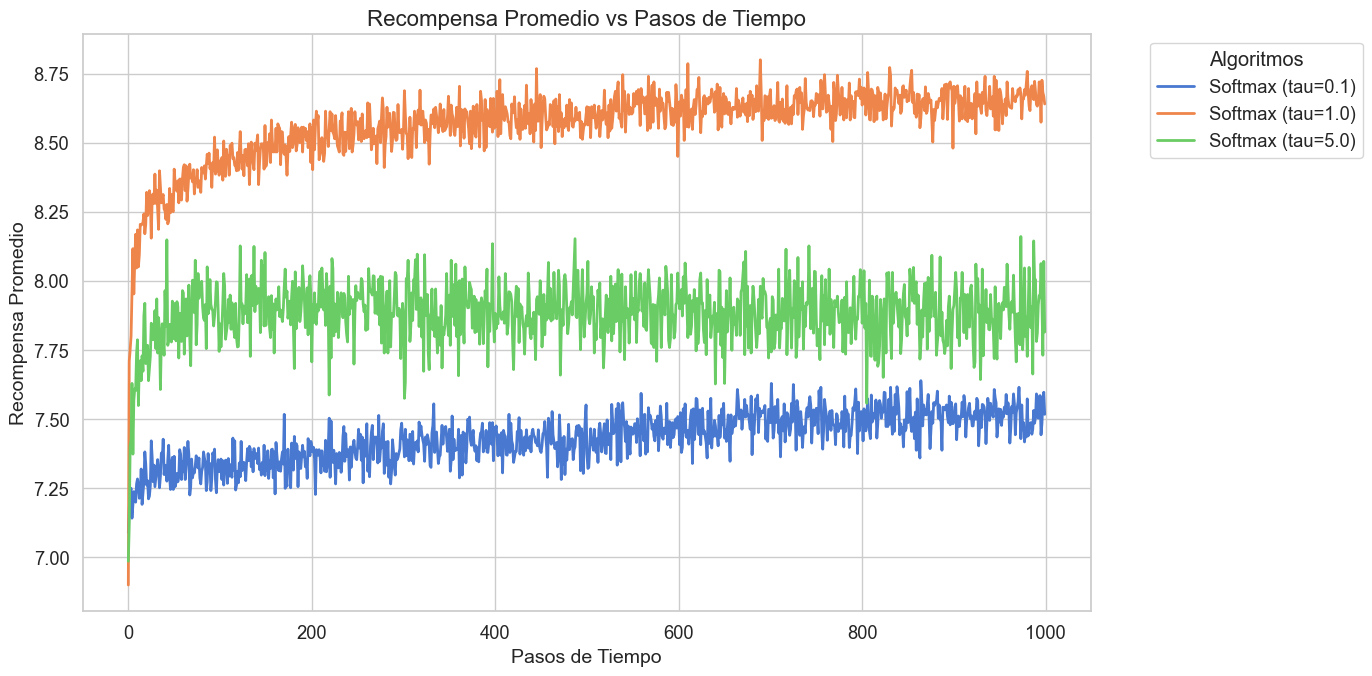

In [10]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)
# plot_optimal_selections(steps, optimal_selections_binomial, algorithms)

### Análisis del Algoritmo Softmax (Distribución Binomial)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que la poca exploración del algoritmo hace que se consiga un poco de mejora a lo largo del tiempo, pero aún así genera los peores resultados de los 3 algoritmos.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, podemos ver una mejora en el tiempo hasta llegar más o menos al paso 500, en el cual el algoritmo converge y se queda proximo a un valor de 8,6, que se aproxima a nuestro valor estimado de 8,93.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. Aquí podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que no se explote un brazo que genere mejores resultados y se queda generando resultados entre 7,75 y 8 aproximadamente.

---

In [11]:
print(f"optimal selections: {optimal_selections_binomial}")

optimal selections: [[0.128 0.132 0.132 ... 0.138 0.138 0.138]
 [0.114 0.134 0.144 ... 0.224 0.212 0.22 ]
 [0.1   0.12  0.108 ... 0.102 0.122 0.13 ]]


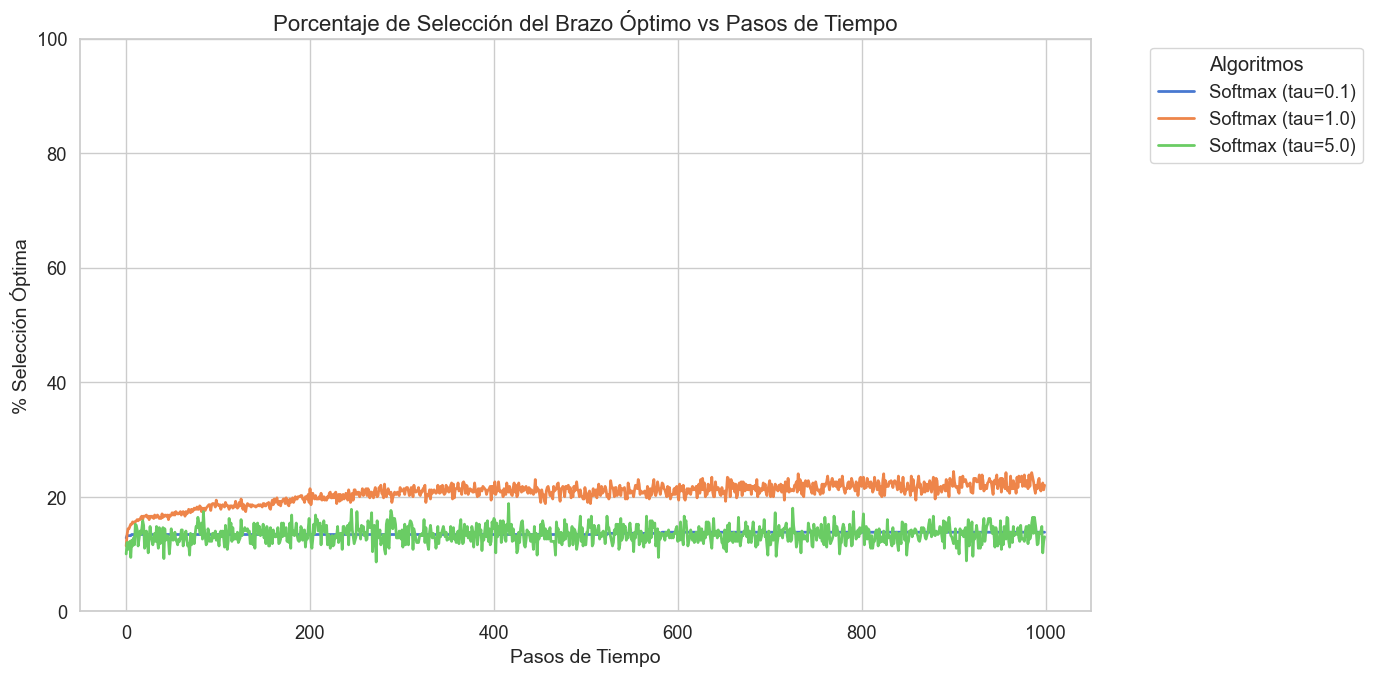

In [12]:
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y solo llegamos a un 15% de selección del brazo óptimo aproximadamente.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este paso podemos ver una mejora a lo largo del tiempo, pero aún así solo consigue superar por poco el 20% en el paso 1000. Aún así, en este caso los resultados obtenidos por los brazos elegidos no han sido tan malos como refleja esta gráfica, aunque no ha conseguido alcanzar la recompensa esperada.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que se quede en un 15% de selección del brazo óptimo.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

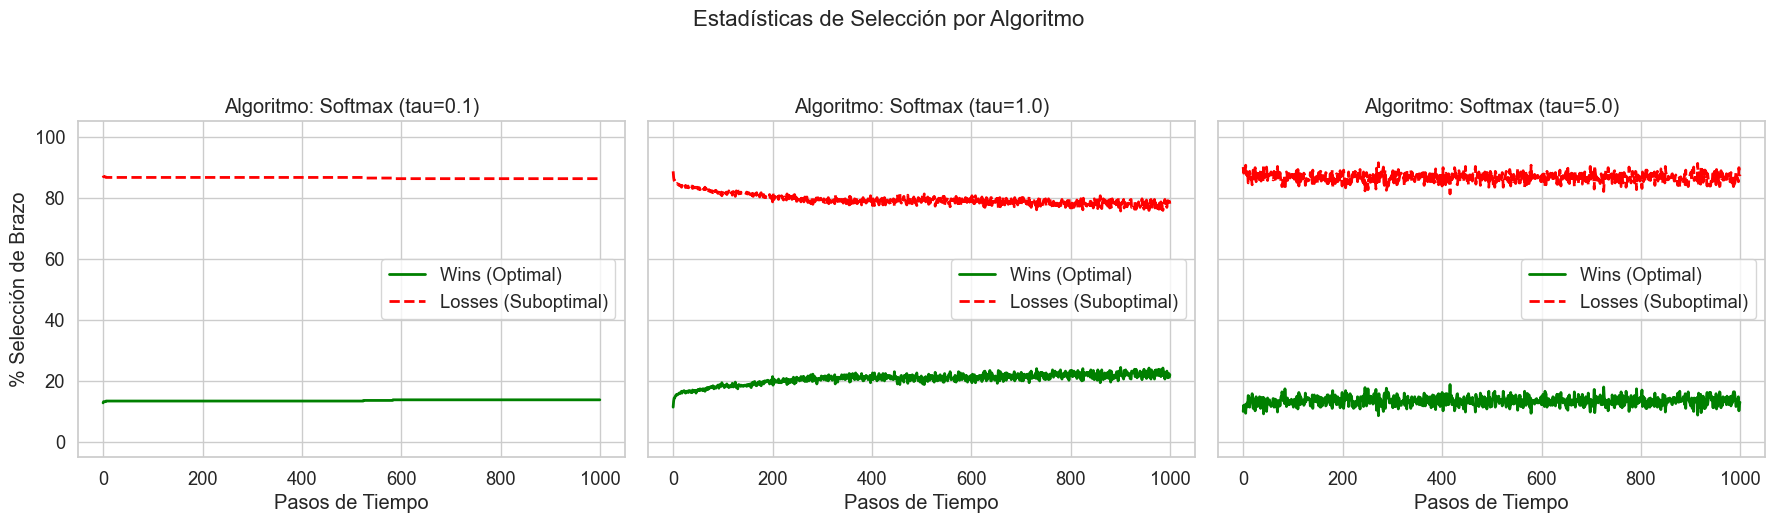

In [13]:
plot_arm_statistics(arm_stats_binomial, algorithms)

## Ejecución del experimento con distribución Bernoulli

Por último, vamos a probar los algoritmos con la distribución de Bernoulli.

In [14]:
# Creación del bandit
bandido = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_bernoulli, optimal_selections_bernoulli, arm_stats_bernoulli = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.74), ArmBernoulli(p=0.25), ArmBernoulli(p=0.69), ArmBernoulli(p=0.05), ArmBernoulli(p=0.80), ArmBernoulli(p=0.03), ArmBernoulli(p=0.11), ArmBernoulli(p=0.03), ArmBernoulli(p=0.40), ArmBernoulli(p=0.36)
Optimal arm: 5 with expected reward=0.8030830250059215


### Visualización de los resultados del experimento Bernoulli

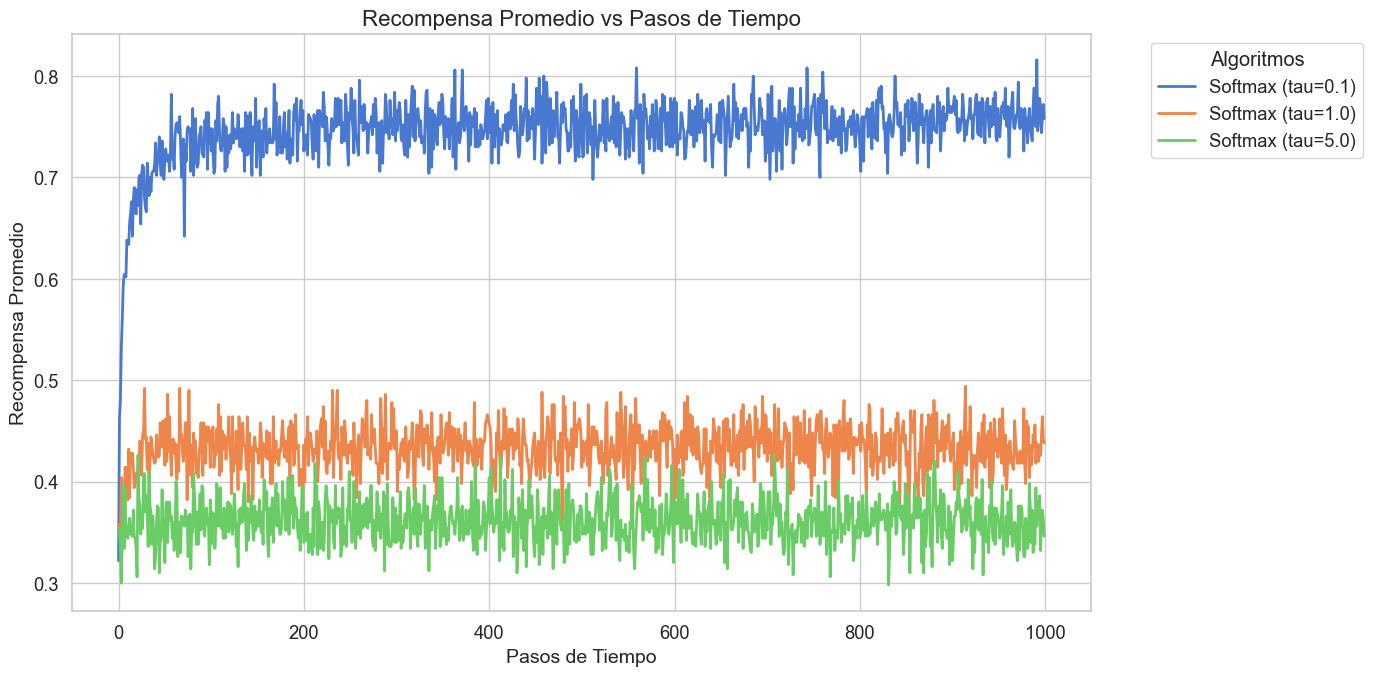

In [15]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernoulli, algorithms)
# plot_optimal_selections(steps, optimal_selections_bernoulli, algorithms)

### Análisis del Algoritmo Softmax (Distribución Bernoulli)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. En este caso, a pesar de la poca exploración, si podemos ver como el algoritmo pega una mejora al principio y consigue llegar a recompensas de 0,75, por lo que estamos cerca del 0,8 de recompensa esperada.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, si podemos ver que hay una mejora al principio pero debido a la mayor exploración se queda en un valor aproximado de 0,45 en vez de explotar brazos con mejores recompensas.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver lo mismo que en el algoritmo anterior, pero al tener una mayor exploración, los resultados son incluso peores, quedandonos sobre un 0,35.

---

In [16]:
print(f"optimal selections: {optimal_selections_bernoulli}")

optimal selections: [[0.114 0.178 0.196 ... 0.512 0.492 0.494]
 [0.092 0.124 0.08  ... 0.144 0.13  0.132]
 [0.104 0.118 0.086 ... 0.1   0.102 0.108]]


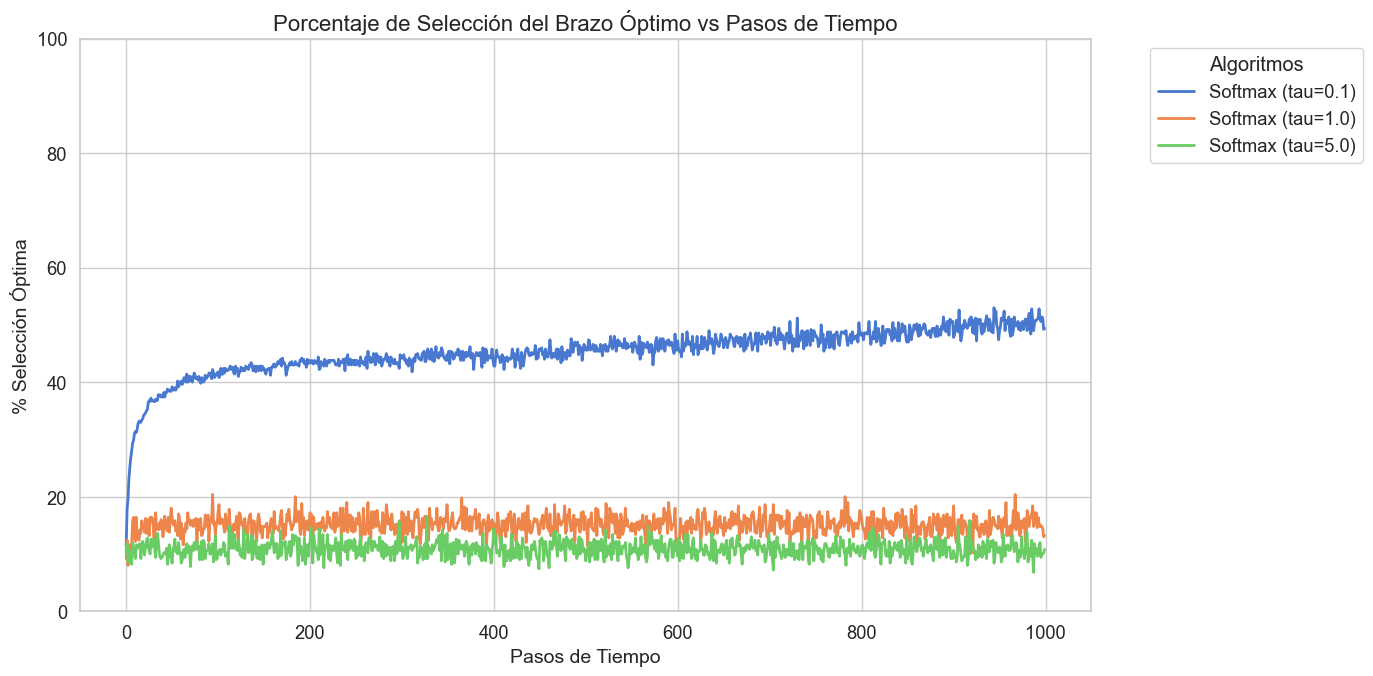

In [17]:
plot_optimal_selections(steps, optimal_selections_bernoulli, algorithms)

### Análisis detallado de la selección óptima


El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Aún así, podemos ver una mejora a lo largo del tiempo, hasta llegar a un 50% de selección del brazo óptimo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso podemos ver que la exploración hace que no se consiga encontrar un brazo con buenos resultados, quedandonos por debajo de un 20% de selección del brazo óptimo.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver el mismo problema que en el algoritmo anterior, pero al tener mayor exploración los resultados son incluso peores.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

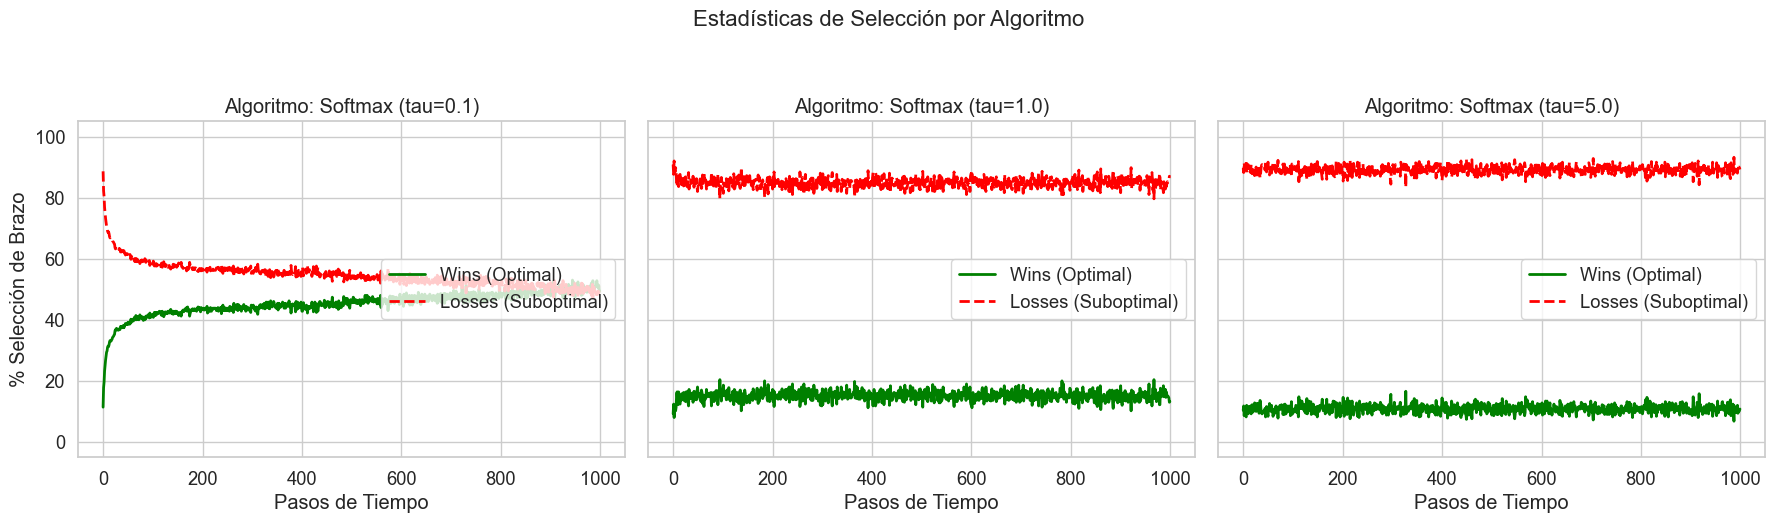

In [18]:
plot_arm_statistics(arm_stats_bernoulli, algorithms)

## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo Softmax, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **Softmax** equilibra la exploración y la explotación con el parámetro tau:
* **Azul (c=0.1):** Excepto para el caso de la distribución de Bernoulli, podemos ver que tan poca exploración hace que el algoritmo se atasque en un brazo que genera malas recompensas y no consigue mejorar a lo largo del tiempo.
* **Naranja (c=1):** Para el caso de la distribución normal y binomial, podemos ver que la exploración extra con respecto al primer algoritmo hace que se consiga una mejora bastante buena en las recompensas obtenidas al avanzar el tiempo. Para el caso de la distribución de Bernoulli, podemos ver que la exploración hace que el algoritmo genere unos resultados bastante malos.
* **Verde (c=5):** En este caso, para las 3 distribuciones, podemos ver que la exploración es escesiva y siempre conseguimos peores resultados que con el segundo algoritmo, que consigue un mejor equilibrio entre exploración y explotación.

#### **2. Convergencia de los algoritmos**
Los algoritmos con un valor de tau más extremo (0,1 y 5) hacen que el algoritmo converga muy rápido, uno por que encuentra un brazo y se queda atascado en el y el otro por que prueba muchos brazos sin quedarse explotando uno. Un valor de tau más equilibrado, como 1, hace que el algoritmo tarde más en converger pero consigue encontrar mejores brazos y conseguir en general mejores recompensas.

#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **tau=1** nos permite encontrar brazos que generen buenas recompensas y aún así explotar esos brazos lo suficiente como para mantener buenos resultados.
- **Una excesiva explotación (tau=0.1)** lleva a un desempeño deficiente, ya que se queda atascado en un brazo y no prueba lo suficiente para encontrar brazos mejores.
- **Una excesiva exploración (tau=5)** también lleva a un desempeño deficiente, ya que el agente puede quedarse probando brazos continuamente en vez de centrarse en el que genere buenos resultados.

En conclusión, **los gráficos muestran como un nivel equilibrado de exploración y explotación permite al algoritmo encontrar brazos que son buenos y explotarlos a lo largo del tiempo**.